In [3]:
!pip install scikit-learn-intelex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn_intelex-2021.6.3-py37-none-manylinux1_x86_64.whl (87 kB)
  Using cached daal4py-2021.6.3-py37-none-manylinux1_x86_64.whl (26.0 MB)
     |████████████████████████████████| 300.3 MB 17 kB/s 
     |████████████████████████████████| 4.0 MB 48.6 MB/s 


In [4]:
from sklearnex import patch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
import time
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('ggplot')
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# Here we are importing the h5 file and create a dataframe.

In [6]:
file = h5py.File('Data_Fuchs_v_2.8_Wright_Pat_Narrow_Range_with_Focal_Dist_energy_limit_0.01_deviation_0.1_lambda_um_0.8_points_100000_seed_1996.h5','r')
file_dict = dict()
for i in file.keys():
    file_dict[i] = file[i][:]
file.close()
physics = pd.DataFrame(file_dict)
physics.columns

Index(['Avg_Proton_Energy_(MeV)', 'Focal_Distance_(um)', 'Intensity_(W_cm2)',
       'Max_Proton_Energy_(MeV)', 'Pulse_Duration_(fs)', 'Spot_Size_(FWHM um)',
       'Target_Thickness (um)', 'Total_Proton_Energy_(MeV)'],
      dtype='object')

# Here we specify the input and output variables

In [7]:
outputs = ['Max_Proton_Energy_(MeV)', 'Total_Proton_Energy_(MeV)', 'Avg_Proton_Energy_(MeV)']

In [8]:
# this is to avoid copying a pasting
inputs = []
for i in physics.columns:
    if i in outputs:
        continue
    else:
        inputs.append(i)
inputs

['Focal_Distance_(um)',
 'Intensity_(W_cm2)',
 'Pulse_Duration_(fs)',
 'Spot_Size_(FWHM um)',
 'Target_Thickness (um)']

In [9]:
df = physics.copy()

In [10]:
df.head()

,Avg_Proton_Energy_(MeV),Focal_Distance_(um),Intensity_(W_cm2),Max_Proton_Energy_(MeV),Pulse_Duration_(fs),Spot_Size_(FWHM um),Target_Thickness (um),Total_Proton_Energy_(MeV)
0,0.000449,-1.968815,1.007714e+18,0.001271,40.0,2.0,2.110420,1.834339e-09
1,0.000083,0.496702,1.056169e+18,0.000249,40.0,2.0,9.746836,1.300155e-10
2,0.000390,-0.700041,1.599248e+18,0.001403,40.0,2.0,3.851590,1.600214e-09
3,0.000220,-4.482165,1.399695e+18,0.000810,40.0,2.0,5.306550,7.667781e-10
4,0.000495,-3.946731,1.986290e+18,0.001313,40.0,2.0,4.253388,2.107820e-09


##### Dropping the columns with constant values

In [11]:
df.drop([inputs[2], inputs[3]], axis= 1, inplace= True)
inputs.remove('Pulse_Duration_(fs)')
inputs.remove('Spot_Size_(FWHM um)')

In [12]:
df

,Avg_Proton_Energy_(MeV),Focal_Distance_(um),Intensity_(W_cm2),Max_Proton_Energy_(MeV),Target_Thickness (um),Total_Proton_Energy_(MeV)
0,0.000449,-1.968815,1.007714e+18,0.001271,2.110420,1.834339e-09
1,0.000083,0.496702,1.056169e+18,0.000249,9.746836,1.300155e-10
2,0.000390,-0.700041,1.599248e+18,0.001403,3.851590,1.600214e-09
3,0.000220,-4.482165,1.399695e+18,0.000810,5.306550,7.667781e-10
4,0.000495,-3.946731,1.986290e+18,0.001313,4.253388,2.107820e-09
...,...,...,...,...,...,...
99995,0.000566,7.940980,3.786020e+18,0.001586,6.322298,2.906831e-09
99996,0.000113,-0.515806,1.787663e+18,0.000373,9.653924,3.666526e-10
99997,0.000805,-3.707250,3.064149e+18,0.002057,3.854748,4.862900e-09
99998,0.000500,-0.030692,1.736724e+18,0.001720,3.191409,2.640352e-09


##### The rows that contain negative Max Proton Energy will be dropped.

In [13]:
df = df[df[outputs[0]] > 0]

In [14]:
# df.to_csv('raw_data.csv', index=False)

##### The train and split sets will also be created here for df.

In [114]:
X_train, X_test, y_train, y_test = train_test_split(df[inputs], df[outputs], test_size=0.80, random_state=6991)

##### Standardizing the data

In [115]:
scaler = StandardScaler()


In [116]:
X_train_means = X_train.mean()
X_train_stds = X_train.std(ddof=1)
X_train_norm = (X_train - X_train_means) / X_train_stds

y_train_means = y_train.mean()
y_train_stds = y_train.std(ddof=1)
y_train_norm = (y_train - y_train_means) / y_train_stds

X_test_means = X_test.mean()
X_test_stds = X_test.std(ddof=1)
X_test_norm = (X_test - X_test_means) / X_test_stds

y_test_means = y_test.mean()
y_test_stds = y_test.std(ddof=1)
y_test_norm = (y_test - y_test_means) / y_test_stds

In [117]:
X_train_norm.head()

,Focal_Distance_(um),Intensity_(W_cm2),Target_Thickness (um)
42890,-1.488610,0.170657,-0.018175
63509,0.421231,0.164718,1.511871
75258,-1.620980,1.394972,0.124223
91910,0.646830,-0.633734,-0.191761
26848,-0.727591,-1.180846,0.889005


# Support Vector Regression model (SVR)

##### If we use the y_train_norm set, then we have to be careful of using np.log on negative values.

In [118]:
np.min(y_train_norm)

Max_Proton_Energy_(MeV)     -0.914573
Total_Proton_Energy_(MeV)   -0.619317
Avg_Proton_Energy_(MeV)     -0.930973
dtype: float64

##### First we create a model.

In [119]:
start_time = time.process_time()

In [120]:
svr_poly = SVR(kernel="poly",
               C=9.4,
               gamma="auto",
               degree=3,
               epsilon=0.001,
               coef0=1.2
               )
# svr_poly = LinearSVR(epsilon=0.45,
#                      tol=0.0001,
#                      C=1.0,
#                      loss='epsilon_insensitive',
#                      fit_intercept=True,
#                      intercept_scaling=1.0,
#                      dual=True,
#                      verbose=0,
#                      random_state=None,
#                      max_iter=5000
#                      )

In [121]:
svr_poly.fit(X_train_norm, np.log(y_train[outputs[0]]))

SVR(C=9.4, coef0=1.2, epsilon=0.001, gamma='auto', kernel='poly')

In [122]:
my_pred = np.exp(svr_poly.predict(X_train_norm))

##### CPU time to run, train, and predict data

In [123]:
end_time = time.process_time()
total_time = end_time - start_time
print(f'The CPU time for this model to run is {total_time} seconds.')

The CPU time for this model to run is 105.27278366499999 seconds.


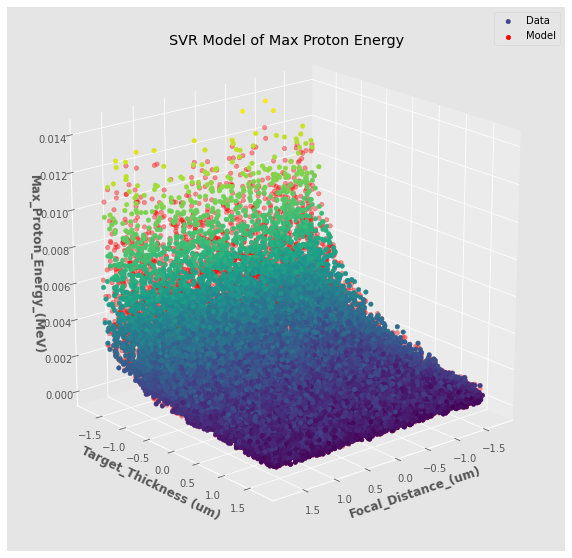

In [124]:
fig2 = plt.figure(figsize=(10, 10))
ax = fig2.add_subplot(projection='3d')
ax.scatter(X_train_norm[inputs[0]],
           X_train_norm[inputs[2]],
           y_train[outputs[0]],
           c = np.sqrt(y_train[outputs[0]]),
           alpha = 1,
           label= 'Data')
ax.scatter(X_train_norm[inputs[0]],
           X_train_norm[inputs[2]],
           my_pred,
           c = 'red',
           alpha= .4,
           label= 'Model')
ax.set_title('SVR Model of Max Proton Energy')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[2]}', fontweight ='bold')
ax.set_zlabel(f'{outputs[0]}', fontweight ='bold')
ax.view_init(20, 50)
plt.legend(loc="upper right")
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_alpha(1)
leg.legendHandles[0].set_alpha(1)
plt.show()

##### An error dataframe will be created for the log transformed data model for the testing sets. This dataframe will also contain the predicted values of the log model, and it will contain the predicted values of the model converted back into its original non log format.

In [125]:
error_3d = X_test_norm.copy()
error_3d['Predictions'] = np.exp(svr_poly.predict(X_test_norm))
error_3d[outputs[0]] = y_test[outputs[0]].copy()
error_3d['Relative Error'] = np.abs((error_3d[outputs[0]] - error_3d['Predictions']) / error_3d[outputs[0]]) * 100

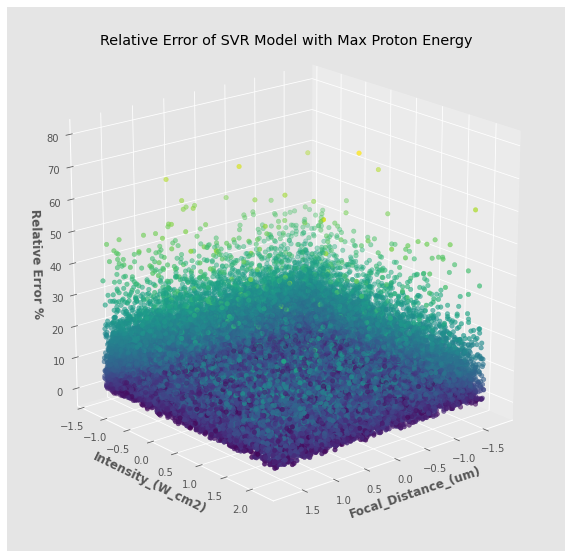

In [126]:
fig3 = plt.figure(figsize=(10, 10))
ax = fig3.add_subplot(projection='3d')
ax.scatter(X_test_norm[inputs[0]],
           X_test_norm[inputs[1]],
           error_3d['Relative Error'],
           c = np.sqrt(error_3d['Relative Error']))
ax.set_title('Relative Error of SVR Model with Max Proton Energy')
ax.set_xlabel(f'{inputs[0]}', fontweight ='bold')
ax.set_ylabel(f'{inputs[1]}', fontweight ='bold')
ax.set_zlabel(f'Relative Error %', fontweight ='bold')
ax.view_init(20, 50)
plt.show()

# Summary

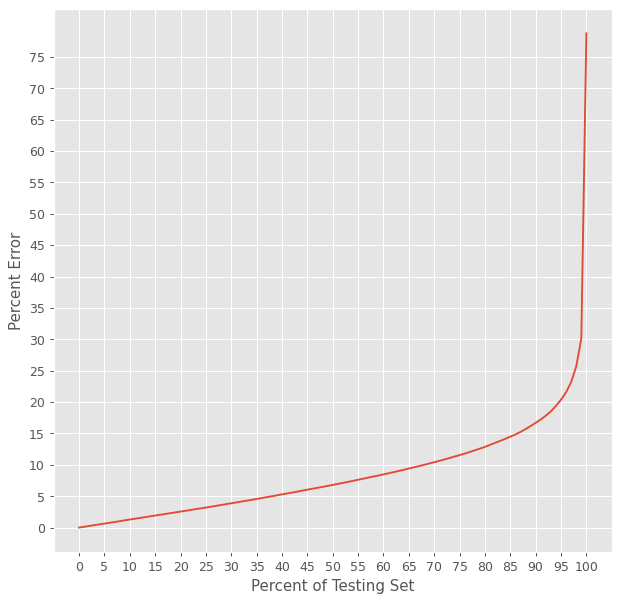

In [127]:
x = np.arange(0, 101, 1)
idk = np.zeros(101)

for i in range(len(idk)):
    idk[i] = np.percentile(error_3d['Relative Error'], x[i])


figure(figsize=(8, 8), dpi=90)
x_ticks = np.arange(0, 101, 5)
y_ticks = np.arange(0, np.max(error_3d['Relative Error']) +1, 5)
plt.xticks(x_ticks)
plt.yticks(y_ticks)
plt.xlabel('Percent of Testing Set')
plt.ylabel('Percent Error')
plt.plot(x, idk)
plt.show()

In [128]:
print(f'Size of training set| {len(X_train)}\nSize of testing set | {len(X_test)}')

Size of training set| 20000
Size of testing set | 80000


In [129]:
mean_squared_error(y_test[outputs[0]], error_3d['Predictions'])

6.44844639028443e-08

In [130]:
print(f'CPU\nHours  | {total_time // 60**2}\nMinutes| {total_time // 60}\nSeconds| {np.abs(total_time - 60 * (total_time // 60 ))}')

CPU
Hours  | 0.0
Minutes| 1.0
Seconds| 45.27278366499999


In [131]:
r2_score(y_test[outputs[0]], error_3d['Predictions'])

0.9794516114866406

In [132]:
np.percentile(error_3d['Relative Error'], 95)

20.366917201093028

# Optimizing the hyperparameters

In [133]:
# parameters = {'kernel': ['poly'],
#               'C': [9.39, 9.4, 9.41],
#               'degree': [3],
#               'gamma': ['auto'],
#               'epsilon': [.001],
#               'coef0': [1, 1.2, 1.25]
#               }

In [134]:
# svr = SVR()

In [135]:
# clf = GridSearchCV(svr,
#                    parameters,
#                    n_jobs= -1,
#                    verbose= 2,
#                    cv = 5
#                    )

In [136]:
# y_train_log = np.log(y_train[outputs[0]])
# clf.fit(X_train_norm, y_train_log)

In [137]:
# clf.best_params_

In [138]:
# clf.best_score_